In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

In [5]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
args.subject = "BL"
# args.conditions = ["Response", "Choice"]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_res = io_utils.read_anova_good_units(args, "95th", return_pos=False)

In [6]:
good_pref_res.groupby("feat").PseudoUnitID.nunique()

feat
CIRCLE       1
CYAN         3
ESCHER      14
GREEN        5
MAGENTA      1
POLKADOT     2
RIPPLE       6
SQUARE       3
STAR        11
SWIRL        6
TRIANGLE     6
YELLOW       2
Name: PseudoUnitID, dtype: int64

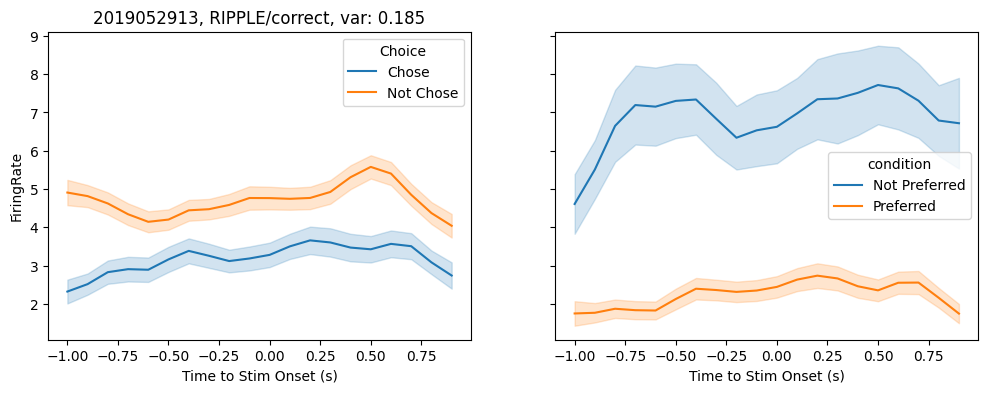

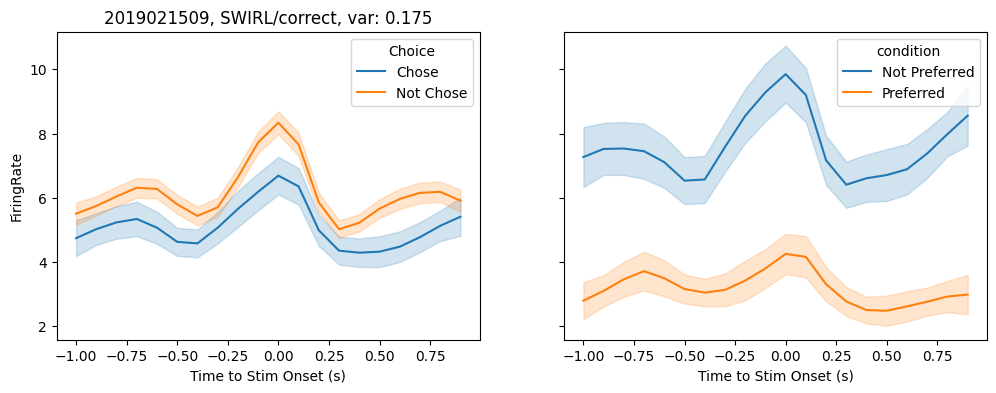

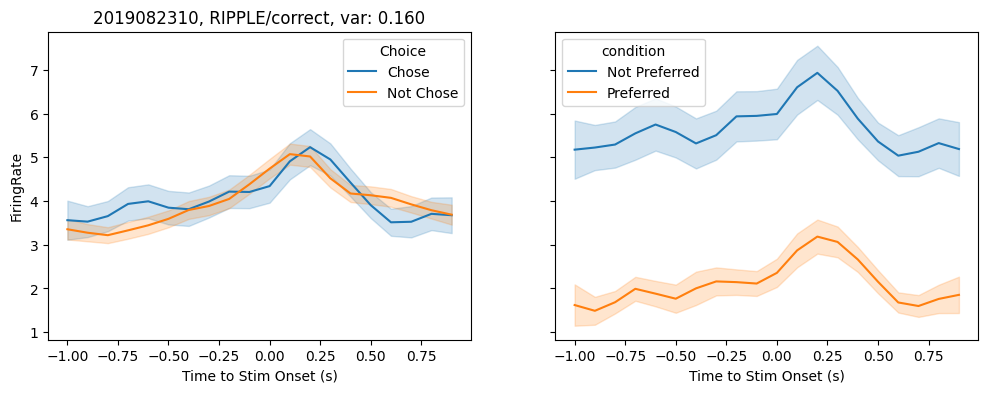

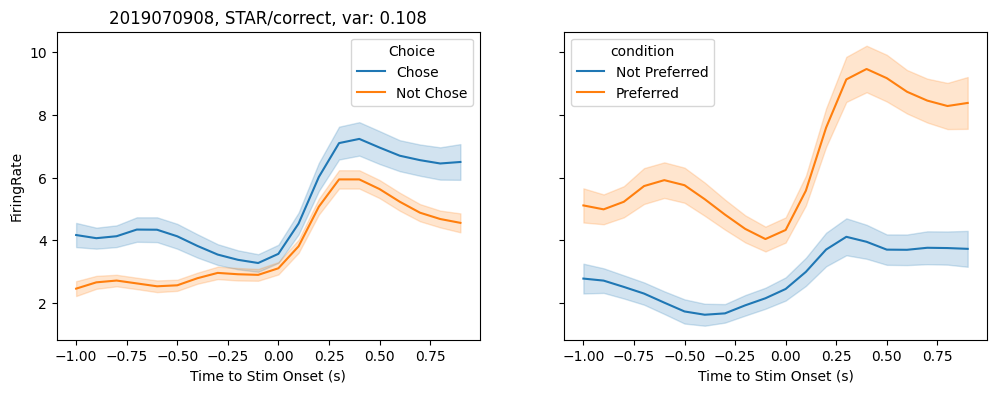

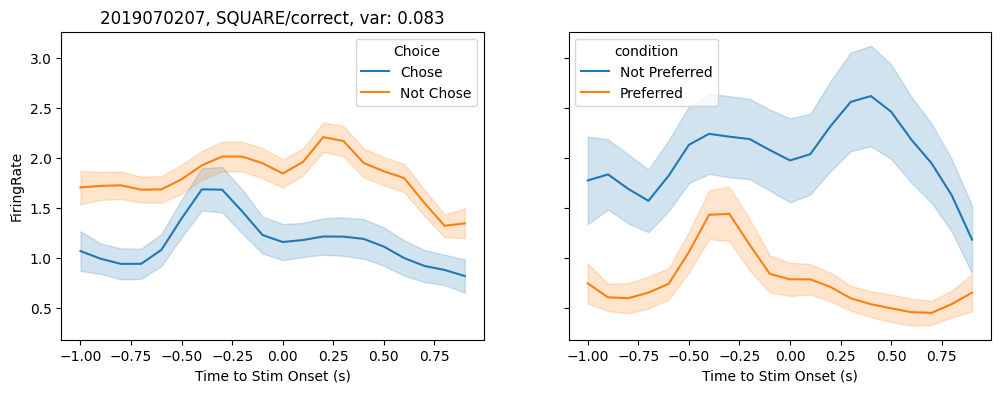

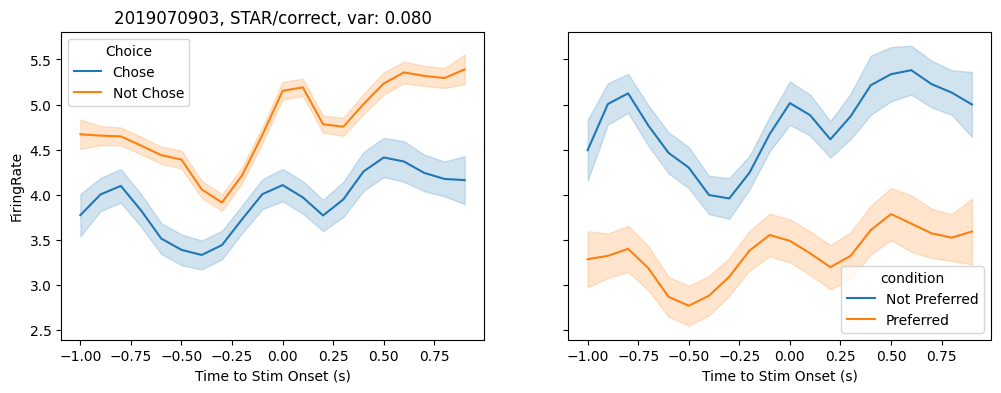

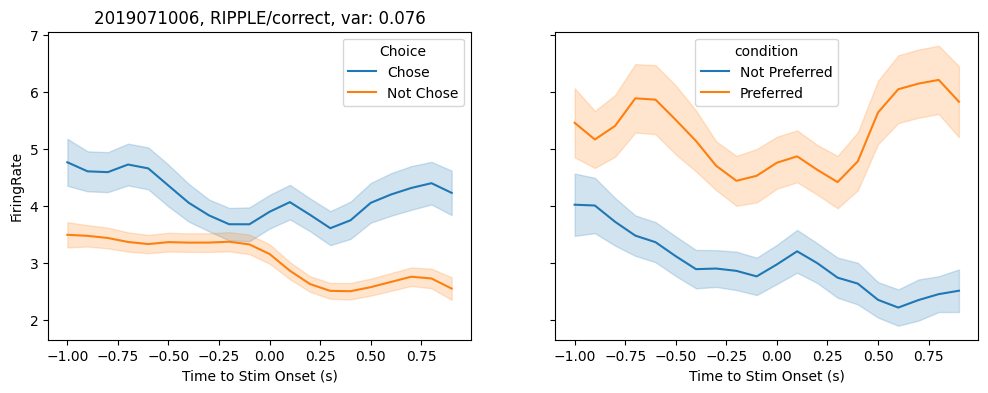

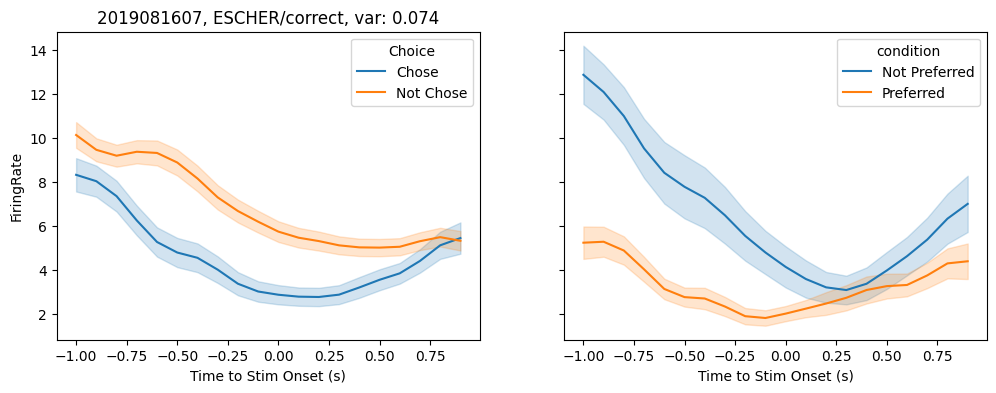

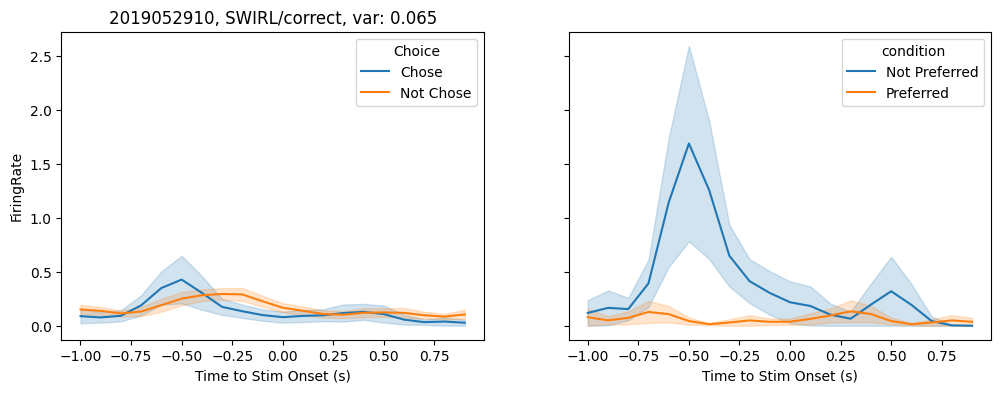

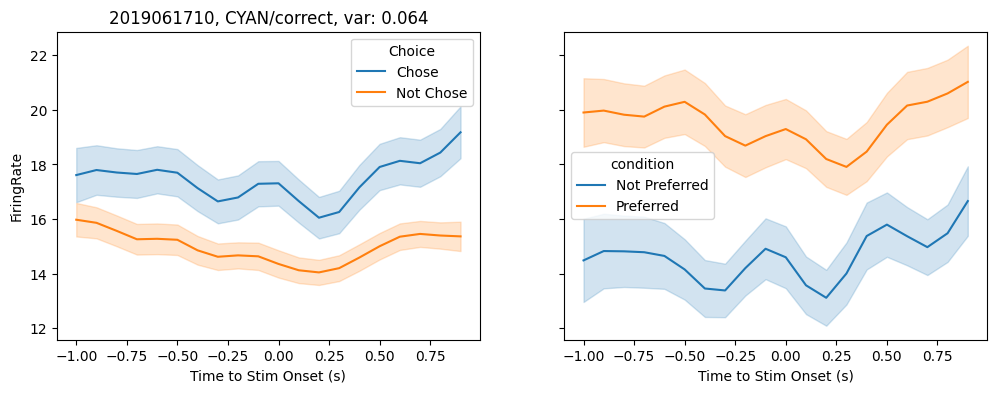

In [7]:
to_vis = good_pref_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    args.time_range = None

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    args.beh_filters = {"PreferredChosen":True, "Response": "Correct"}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    choice_order = np.sort(data["Choice"].unique())
    sns.lineplot(data, x="Time", y="FiringRate", hue="Choice", hue_order=choice_order, errorbar="se", ax=ax1)
    ax1.set_xlabel("Time to Stim Onset (s)")

    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    cond_order = np.sort(data["condition"].unique())

    sns.lineplot(data, x="Time", y="FiringRate", hue="condition", hue_order=cond_order, errorbar="se", ax=ax2)
    ax2.set_xlabel("Time to Stim Onset (s)")


    ax1.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}")